In [2]:
%%capture
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl


In [4]:
location = (r'C:\PhD\fann_0\widths')
os.chdir(location)
value_list = [1,2,3,4,5,6,7]
for i in value_list:
    contour_file = 'g'+str(i)+'_flow_width.tif'
    #print(contour_file)
    input_geotiff = gdal.Open(contour_file)
    x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
    contour_layer = 1 - x

    input_geotiff_slope = gdal.Open('fann_0_slope.tif')
    sx = np.array(input_geotiff_slope.GetRasterBand(1).ReadAsArray())
    slope_layer = sx
    g_slope = np.multiply(slope_layer, contour_layer).astype('Float64')
    slope_cont = g_slope > 0
    contour_values = slope_layer[slope_cont]
    contour_values
    print(i, np.mean(contour_values))


C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


1 3.68698
2 14.2127
3 28.8461
4 26.7224
5 22.4218
6 25.3625
7 29.4181


In [11]:
location = (r'C:\PhD\fann_17\widths')
os.chdir(location)
value_list = [1,2,3,4,5,6,7]
for i in value_list:
    contour_file = 'g'+str(i)+'_flow_width.tif'
    #print(contour_file)
    input_geotiff = gdal.Open(contour_file)
    x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
    contour_layer = 1 - x

    input_geotiff_mrvbf = gdal.Open('fann_17_mrvbf.tif')
    sx = np.array(input_geotiff_mrvbf.GetRasterBand(1).ReadAsArray())
    mrvbf_layer = sx
    g_mrvbf = np.multiply(mrvbf_layer, contour_layer).astype('Float64')
    mrvbf_cont = g_mrvbf > 0
    contour_values = mrvbf_layer[mrvbf_cont]
    contour_values
    print(i, np.mean(contour_values))


C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


1 2.60898
2 3.18186
3 2.84718
4 2.97055
5 2.96471
6 1.9453
7 2.41865


In [65]:
initial_resolution = 1
location = (r'C:/PhD/junk/fann_0_gullies')
os.chdir(location)
value_list = [1,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,24,25,26,27,28,29,30,32,33]
for i in value_list:
    contour_file = 'g'+str(i)+'_cont.tif'
    #print(contour_file)
    input_geotiff = gdal.Open(contour_file)
    x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
    x[x>0]=1
    contour_layer = 1 - x

    input_geotiff_slope = gdal.Open('fann_0_M8_sca.tif')
    sx = np.array(input_geotiff_slope.GetRasterBand(1).ReadAsArray())
    sca_layer = sx
    g_sca = np.multiply(sca_layer, contour_layer).astype('Float64')
    sca_cont = g_sca > 0
    sca_values = sca_layer[sca_cont]
    sca_values
    print(i, np.amax(sca_values))


C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  app.launch_new_instance()


1 272.827531283
4 96.5000047361
5 42.9501357894
6 159.411173565
7 8615.37078643
8 425.642230044
9 228.801440217
10 75.8554481047
12 243.802191099
13 184.511442155
14 811.295051839
15 154.746532113
16 70.2807231919
17 92.1960564997
18 158.14986021
19 142.936485829
20 151.182457386
24 513.374467638
25 7498.72944285
26 1919.73005914
27 1653.23639683
28 5118.83224453
29 186.2328818
30 221.794562783
32 131.297609766
33 608.363485957


In [63]:
input_geotiff = gdal.Open('g25_cont.tif')
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x[x>0]=1
contour_layer = 1 - x

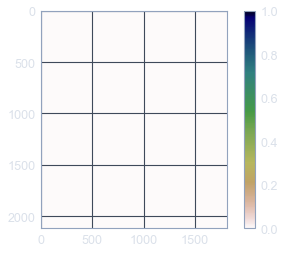

In [64]:
plt.imshow(contour_layer, cmap="gist_earth_r");
plt.colorbar();

In [15]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [26]:
np_array_to_Geotiff('fann_0_test_slope.tif', input_geotiff, g_slope, 
                    g_slope.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
